In [ ]:
import pandas as pd
import seaborn as sns
import os
import pdb
import matplotlib.pyplot as plt
import re
import time
import unicodedata

In [ ]:
def load_data(n_files = 1):

  base_path = "/content/drive/MyDrive/MLDM Project/data-train/"
  common_file_name= "train_data_part_"

  products_file_name = "products_data.csv"

  # Test data, next future order
  test_data = "test_data.csv"

  historic_data = list()

  # Load historic train data
  for i in range(0, n_files):
    historic_data.append(pd.read_csv(os.path.join(base_path, common_file_name + str(i+1) + ".csv")))

  # Join all the training data
  historic_df = pd.concat(historic_data, ignore_index=True)

  # Load product table
  product_df = pd.read_csv(os.path.join(base_path, products_file_name))

  # Load next purchase table
  next_purchase_df = pd.read_csv(os.path.join(base_path, test_data))

  return historic_df, next_purchase_df, product_df

In [ ]:
def remove_accents(input_str):
  return ''.join(
      c for c in unicodedata.normalize('NFD', input_str)
      if unicodedata.category(c) != 'Mn'
  )

# Define a function to pre-process text product descriptions
def process_description(s, min_word_length, n_words):

  # Normalize text to remove accents
  s = remove_accents(s)

  # Replace dots in words with spaces to split subwords
  s = re.sub(r'\.', ' ', s)

  # Remove punctuation, special symbols
  s = re.sub(r'[^\w\s]', '', s)

  # filter word length
  words = [
      word for word in s.split()
      if len(word) >= min_word_length and not re.search(r'\d', word)
  ]

  # Get n words to represent a product description
  if n_words > 0:
      words = words[:n_words]

  # Join the words into a single string
  processed = ' '.join(words)

  return processed


In [ ]:
def process_text_descriptions(next_purchase_df, product_df, max_length, min_word_length, n_words):
  ''' This function returns a dataframe that contains: A row for each customer_id,
      with a list of product_ids that are part from the next future order,
      and a string with the concatenated descriptions for all the products of the next future order.

      Additionally, a preprocessing for the concatenated product descriptions is applied.'''

  next_purchase_df = next_purchase_df.merge(
      product_df[['product_id', 'product_description']],
      on='product_id',
      how='left'
  )

  # Preprocess product text descriptions
  next_purchase_df['product_description'] = next_purchase_df['product_description'].apply(lambda x: process_description(x, min_word_length=min_word_length, n_words=n_words))

  # Concatenate product descriptions and products ids as a single string
  next_purchase_df = next_purchase_df.groupby('customer_id').agg(
      product_descriptions=('product_description', lambda x: ' '.join(x)), # Concatenate product_descriptions
      product_ids=('product_id', lambda x: ', '.join(map(str, x)))  # Concatenate product_ids as a string

  ).reset_index()

  # Truncate the 'product_description'  to 512 characters
  next_purchase_df['product_descriptions'] = next_purchase_df['product_descriptions'].str[:512]

  return next_purchase_df

In [ ]:
def get_last_n_transactions(df, n=2):

  df = df.sort_values(by=['date', 'transaction_id'])
  # Get the last n unique transaction_id for each customer_id
  last_n_transactions = (
      df.groupby('customer_id')['transaction_id']
      .apply(lambda x: x.drop_duplicates().tail(n))
      .reset_index(drop=True)
  )

  # Filter the original DataFrame to get all products from last transactions
  result_df = df[df['transaction_id'].isin(last_n_transactions)]

  return result_df

In [ ]:
def create_dataframes(last_transactions, max_length, n_files, min_word_length, n_words):
  # Load Data
  historic_df, next_purchase_df, product_df = load_data(n_files=n_files)
  # Load n last transactions from historic purchases
  last_transactions_df = get_last_n_transactions(historic_df, n=last_transactions)
  # Flatten n las transactions as a single text
  next_purchase_processed = process_text_descriptions(next_purchase_df, product_df, max_length, min_word_length, n_words)
  # Flatten the next future transaction as a single text
  historic_processed = process_text_descriptions(last_transactions_df, product_df, max_length, min_word_length, n_words)

  # Combine the two dataframes, historic and future
  train_data = pd.merge(historic_processed, next_purchase_processed,
    on='customer_id',
    how='left',
    suffixes=('_historic', '_future')
  )

  return historic_processed, next_purchase_processed, train_data, product_df


In [ ]:
start_time = time.time()
# Create datasets
historic_processed, next_purchase_processed, train_data, product_df = create_dataframes(last_transactions=2, max_length=512, n_files=1, min_word_length=4, n_words=3)

end_time = time.time()
print(f"Execution time: {end_time - start_time:.6f} seconds")

<ipython-input-43-c96f85d2c982>:21: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  product_df = pd.read_csv(os.path.join(base_path, products_file_name))


Execution time: 80.862615 seconds


In [ ]:
train_data.to_csv('/content/drive/MyDrive/MLDM Project/data/train/text-train_data_part_1.csv', index=False)

# For debugging

In [ ]:
train_data.head(10)

,customer_id,product_descriptions_historic,product_ids_historic,product_descriptions_future,product_ids_future
0,Household_1,EMMENTAL RAPE PESTO BASILICO RUCOLA POMME GRAN...,"Product_36019, Product_13365, Product_41853, P...",NATURE DANONE VELOUTE MACHE ETUIS MOUCHOIRS SI...,"Product_45719, Product_170, Product_24334, Pro..."
1,Household_10,ELMT BICARBONATE TARTINE CAMPAGNE BOULANGE LAI...,"Product_76143, Product_60309, Product_40875, P...",COUNTRY CRISP CHOC PARMIGIA RAPE CASA POMPOTES...,"Product_29639, Product_43071, Product_74328, P..."
2,Household_100,MATIN LEGER OEUFS CLASSIC CLASS GRENADE USHUAI...,"Product_27363, Product_23586, Product_22582, P...",COPEAUX POUR RONGEUR BLANC POULET PETITS PANIE...,"Product_68611, Product_65074, Product_80380, P..."
3,Household_1000,DAMANDE POPNUTS HARI VERT XFIN BRUT SIMPLY CHO...,"Product_37381, Product_5403, Product_58139, Pr...",CHOCO CAMEMBERT PORT CLAS MORBIER PORTIONS PTI...,"Product_20725, Product_32213, Product_41686, P..."
4,Household_10000,MACHE SALADE BATAVIA PIECE CELLO ALPHABET PANZ...,"Product_79213, Product_41366, Product_15268, P...",OLIVE COCKTAIL EURO PIPE RIGATE BARILLA MINI T...,"Product_52233, Product_13607, Product_70424, P..."
5,Household_1001,POTIMARRON VELOUTE POTIRON CLASSIC YAOURT NATU...,"Product_34316, Product_54950, Product_18185, P...",YOPLAIT NATURE SUCRE PUREE TOMATE CLAS PINEUC...,"Product_23971, Product_50407, Product_7746, Pr..."
6,Household_1002,SUCRE POUDRE LESS BLEU BANANE DOIGTS SIROP FRA...,"Product_80801, Product_70780, Product_379, Pro...",BEURRE GASTRO POMME JAUN DOSETTES CORSE PLEIN ...,"Product_63301, Product_22896, Product_2343, Pr..."
7,Household_1003,POMELO PIECE VIANDE HACHEE DOLCE PIZZA PROSCIU...,"Product_10212, Product_40168, Product_45518, P...",BANANE DOIGTS LINGET DESINFECT CAROTTE SABLE V...,"Product_379, Product_59792, Product_15779, Pro..."
8,Household_1004,LENOR BOUQUET FLORAL FLAGEOLET BOUQ GARN CHAMA...,"Product_61042, Product_13621, Product_18263, P...",ECHALOTE SAUCISSON CUIT LAIL TABOULE ORIENTAL ...,"Product_38437, Product_4727, Product_28757, Pr..."
9,Household_1005,SALADE COMPOSEE EURO OIGNON ROUGE COEU CABIL P...,"Product_4447, Product_74965, Product_45026, Pr...",CHOU BROCOLIS PARMIGIA RAPE CASA BRIOCHE TRCH ...,"Product_47670, Product_43071, Product_1823, Pr..."


In [ ]:
product_df.product_description.head(50)

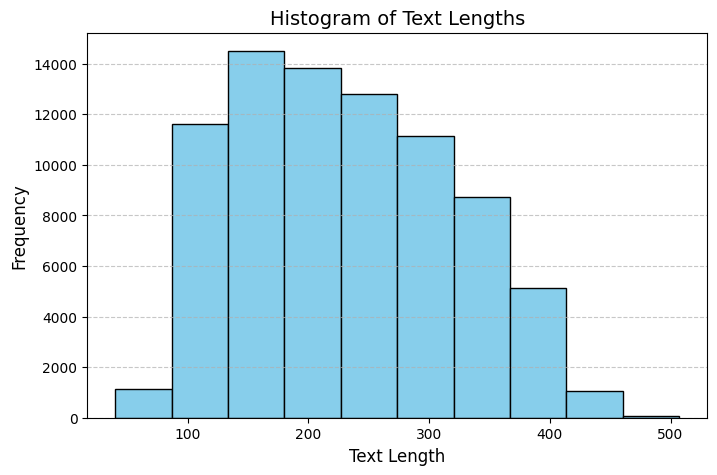

In [ ]:
# Calculate the lengths of text in the column
next_purchase_processed['text_length'] = next_purchase_processed['product_descriptions'].apply(len)

# Plot a histogram
plt.figure(figsize=(8, 5))
plt.hist(next_purchase_processed['text_length'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Text Lengths', fontsize=14)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

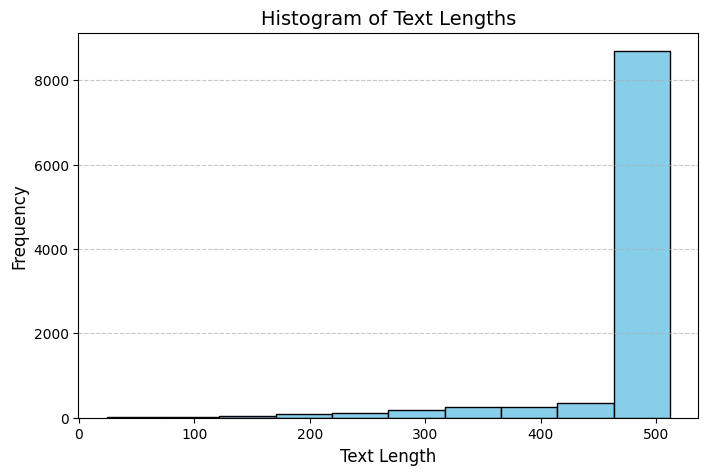

In [ ]:
# Calculate the lengths of text in the column
historic_processed['text_length'] = historic_processed['product_descriptions'].apply(len)

# Plot a histogram
plt.figure(figsize=(8, 5))
plt.hist(historic_processed['text_length'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Text Lengths', fontsize=14)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()